In [184]:
from bs4 import BeautifulSoup
import requests, json
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import OrderedDict
import operator
import os
import sys
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob  #Sentiment Analysis - pip install textblob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# from wordcloud import WordCloud  #pip install
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import gensim
from gensim.models import word2vec
from gensim import corpora

from sklearn.manifold import TSNE

In [185]:
#all data csv files from https://www.kaggle.com/oswinrh/bible

#Load the American Standard Version Bible from csv file (has to be in the same folder as the notebook)

#Description of columns in the CSV file:

# 'id' is a string of the book number (e.g. Genesis = '1')
# plus the chapter (e.g. chapter 1 = '001') 
# plus the verse number (e.g. verse 1 = '001')
# hence, Genesis 1:1 would be "1001001"

# 'b' = book number
# 'c' = chapter number
# 'v' = verse number
# 't' = text

df_Bible = pd.read_csv('./t_asv.csv')
df_Bible.head(10)

id  b  c   v                                                  t
0  1001001  1  1   1  In the beginning God created the heavens and t...
1  1001002  1  1   2  And the earth was waste and void; and darkness...
2  1001003  1  1   3  And God said, Let there be light: and there wa...
3  1001004  1  1   4  And God saw the light, that it was good: and G...
4  1001005  1  1   5  And God called the light Day, and the darkness...
5  1001006  1  1   6  And God said, Let there be a firmament in the ...
6  1001007  1  1   7  And God made the firmament, and divided the wa...
7  1001008  1  1   8  And God called the firmament Heaven. And there...
8  1001009  1  1   9  And God said, Let the waters under the heavens...
9  1001010  1  1  10  And God called the dry land Earth; and the gat...

In [186]:
#Rename the columns so that when merging the data frames later the column names will be unique
df_Bible.columns = ['unique_ID', 'book_ID', 'chapter_ID', 'verse_ID', 'text']
df_Bible.head(10)

unique_ID  book_ID  chapter_ID  verse_ID  \
0    1001001        1           1         1   
1    1001002        1           1         2   
2    1001003        1           1         3   
3    1001004        1           1         4   
4    1001005        1           1         5   
5    1001006        1           1         6   
6    1001007        1           1         7   
7    1001008        1           1         8   
8    1001009        1           1         9   
9    1001010        1           1        10   

                                                text  
0  In the beginning God created the heavens and t...  
1  And the earth was waste and void; and darkness...  
2  And God said, Let there be light: and there wa...  
3  And God saw the light, that it was good: and G...  
4  And God called the light Day, and the darkness...  
5  And God said, Let there be a firmament in the ...  
6  And God made the firmament, and divided the wa...  
7  And God called the firmament Heaven. And there...  
8  And God said, Let the waters under the heavens...  
9  And God called the dry land Earth; and the gat...

In [187]:
#topic modeling cleaning function (from https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)

#Get standard english stopwords from NLTK
cachedStopWords = stopwords.words("english")
#Extend the list of stopwords to include old English words found in the Bible 
cachedStopWords.extend(['thou','thee','thy','thine','ye','er','hast',
                        'hath','art', 'wilt', 'didst', 'thyself', 'shalt'])
#convert the stop words list into a set
stop = set(cachedStopWords)
#convert the punctuation characters into a set 
exclude = set(string.punctuation)
#initialize the Lemmatizer to grab only the root of words
lemma = WordNetLemmatizer()
#define a function that can be called to clean each document (verse of the Bible in this case)
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [188]:
#Test the clean(doc) function before using on text of the Bible
test_sentence = 'Hello world! Thy sentence shalt be cleaned immediately.'
test_sentence_clean = clean(test_sentence)
print(test_sentence_clean)

hello world sentence cleaned immediately


In [189]:
# change the "t" (text) column in pandas dataframe to an array of sentences for cleaning
df_text_doc = df_Bible.text.as_matrix()
print(df_text_doc)

['In the beginning God created the heavens and the earth.'
 'And the earth was waste and void; and darkness was upon the face of the deep: and the Spirit of God moved upon the face of the waters.'
 'And God said, Let there be light: and there was light.' ...,
 'and if any man shall take away from the words of the book of this prophecy, God shall take away his part from the tree of life, and out of the holy city, which are written in this book.'
 'He who testifieth these things saith, Yea: I come quickly. Amen: come, Lord Jesus.'
 'The grace of the Lord Jesus be with the saints. Amen.']


In [190]:
#Convert the text of the Bible into an array of tokenized arrays and check the first five
df_doc_clean = [clean(doc).split() for doc in df_text_doc]
print(df_doc_clean[0:5])

[['beginning', 'god', 'created', 'heaven', 'earth'], ['earth', 'waste', 'void', 'darkness', 'upon', 'face', 'deep', 'spirit', 'god', 'moved', 'upon', 'face', 'water'], ['god', 'said', 'let', 'light', 'light'], ['god', 'saw', 'light', 'good', 'god', 'divided', 'light', 'darkness'], ['god', 'called', 'light', 'day', 'darkness', 'called', 'night', 'evening', 'morning', 'one', 'day']]


In [191]:
#create the term dictionary our corpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(df_doc_clean)

In [192]:
#check dictionary that we created from the Bible's corpus (11653 unique tokens from all of
# the 66 books of the Bible combined after cleaning up stopwords and removing punctuation)
print(dictionary)

Dictionary(11652 unique tokens: ['beginning', 'god', 'created', 'heaven', 'earth']...)


In [193]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df_doc_clean]

In [194]:
#check first five lines of the document term matrix
doc_term_matrix[0:5]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(1, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(1, 1), (14, 1), (15, 1), (16, 2)],
 [(1, 2), (7, 1), (16, 2), (17, 1), (18, 1), (19, 1)],
 [(1, 1),
  (7, 1),
  (16, 1),
  (20, 2),
  (21, 2),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1)]]

In [195]:
#data here is 'df_text_doc' derived previously, in a cell above,
#an array of all verses in all 66 books of the Bible
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 5000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_text_doc)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(df_text_doc)
tf_feature_names = tf_vectorizer.get_feature_names()



In [196]:
#print out the first 10 features from the TF-IDF matrix
tfidf_feature_names[0:10]

['aaron',
 'abarim',
 'abated',
 'abdon',
 'abed',
 'abel',
 'abhor',
 'abhorred',
 'abhorreth',
 'abiathar']

In [197]:
#print out the first 10 features from the TF matrix
tf_feature_names[0:10]

['aaron',
 'abarim',
 'abated',
 'abdon',
 'abed',
 'abel',
 'abhor',
 'abhorred',
 'abhorreth',
 'abiathar']

In [198]:

from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [199]:
#display function for both LDA and Non-negative Matrix Factorization (NMF)
# from https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [200]:
no_top_words = 10
print("NMF top 20 topics with top 10 words:\n")
display_topics(nmf, tfidf_feature_names, no_top_words)

NMF top 20 topics with top 10 words:

Topic 0:
jehovah saith house israel hosts word hand day evil did
Topic 1:
thou hast art wilt didst thyself thine said knowest know
Topic 2:
shall come day pass days holy eat thereof fall say
Topic 3:
ye know say hear eat things seek love believe brethren
Topic 4:
unto said say answered come called father speak sent brethren
Topic 5:
thy hand heart servant thine father lovingkindness servants face right
Topic 6:
shalt thou make eat surely thereof thyself die bring gold
Topic 7:
god israel spirit glory fear know law kingdom earth heaven
Topic 8:
children israel thousand tribe according did ammon inheritance levites cities
Topic 9:
thee pray make thine behold come thou bring bless deliver
Topic 10:
son sons father david tribe reigned stead bare jonathan saul
Topic 11:
came word pass saying went day jeremiah days month told
Topic 12:
man men woman behold good house wise evil know young
Topic 13:
hath given spoken taken hand away seen father sent thing


In [201]:
no_top_words = 10
print("LDA top 20 topics with top 10 words:\n")
display_topics(lda, tf_feature_names, no_top_words)

LDA top 20 topics with top 10 words:

Topic 0:
days love seven years old tree died begat jeremiah food
Topic 1:
thereof midst waters cubits priests ark tongue ear money half
Topic 2:
sea round light temple wine new morning thereof entered oil
Topic 3:
people unto hear brought blood sin voice bread jehovah return
Topic 4:
son father city judah sons brethren dwell wife mother called
Topic 5:
hath great time given god faith dead year seek delivered
Topic 6:
cast chief works child places psalm number gate break north
Topic 7:
shall ye unto jehovah saith man god say lord know
Topic 8:
thou thy unto thee said jehovah things god saying shalt
Topic 9:
day set work rest month book sabbath gates doeth stones
Topic 10:
david joy levites zion image tabernacle fallen daniel lift joab
Topic 11:
israel children christ fathers hosts unto jesus born houses beloved
Topic 12:
jehovah did unto according law god took gave eyes word
Topic 13:
come house holy nations brother righteous behold wicked jehovah i

In [202]:
# define a function that accepts text and returns the polarity
def getSentimentPolarity(text):
    return format(TextBlob(text).sentiment.polarity, '.4f')

In [203]:
df_Bible['clean_text'] = df_Bible.text.apply(clean)

In [204]:
df_Bible.head(10)

unique_ID  book_ID  chapter_ID  verse_ID  \
0    1001001        1           1         1   
1    1001002        1           1         2   
2    1001003        1           1         3   
3    1001004        1           1         4   
4    1001005        1           1         5   
5    1001006        1           1         6   
6    1001007        1           1         7   
7    1001008        1           1         8   
8    1001009        1           1         9   
9    1001010        1           1        10   

                                                text  \
0  In the beginning God created the heavens and t...   
1  And the earth was waste and void; and darkness...   
2  And God said, Let there be light: and there wa...   
3  And God saw the light, that it was good: and G...   
4  And God called the light Day, and the darkness...   
5  And God said, Let there be a firmament in the ...   
6  And God made the firmament, and divided the wa...   
7  And God called the firmament Heaven. And there...   
8  And God said, Let the waters under the heavens...   
9  And God called the dry land Earth; and the gat...   

                                          clean_text  
0                 beginning god created heaven earth  
1  earth waste void darkness upon face deep spiri...  
2                           god said let light light  
3      god saw light good god divided light darkness  
4  god called light day darkness called night eve...  
5  god said let firmament midst water let divide ...  
6  god made firmament divided water firmament wat...  
7  god called firmament heaven evening morning se...  
8  god said let water heaven gathered together un...  
9  god called dry land earth gathering together w...

In [205]:
# create a new column for sentiment
df_Bible['sentiment'] = df_Bible.clean_text.apply(getSentimentPolarity)

In [206]:
df_Bible.head(10)

unique_ID  book_ID  chapter_ID  verse_ID  \
0    1001001        1           1         1   
1    1001002        1           1         2   
2    1001003        1           1         3   
3    1001004        1           1         4   
4    1001005        1           1         5   
5    1001006        1           1         6   
6    1001007        1           1         7   
7    1001008        1           1         8   
8    1001009        1           1         9   
9    1001010        1           1        10   

                                                text  \
0  In the beginning God created the heavens and t...   
1  And the earth was waste and void; and darkness...   
2  And God said, Let there be light: and there wa...   
3  And God saw the light, that it was good: and G...   
4  And God called the light Day, and the darkness...   
5  And God said, Let there be a firmament in the ...   
6  And God made the firmament, and divided the wa...   
7  And God called the firmament Heaven. And there...   
8  And God said, Let the waters under the heavens...   
9  And God called the dry land Earth; and the gat...   

                                          clean_text sentiment  
0                 beginning god created heaven earth    0.0000  
1  earth waste void darkness upon face deep spiri...   -0.1000  
2                           god said let light light    0.4000  
3      god saw light good god divided light darkness    0.5000  
4  god called light day darkness called night eve...    0.4000  
5  god said let firmament midst water let divide ...    0.0000  
6  god made firmament divided water firmament wat...    0.0000  
7  god called firmament heaven evening morning se...    0.0000  
8  god said let water heaven gathered together un...   -0.0667  
9  god called dry land earth gathering together w...    0.3167

In [207]:
len(df_Bible['sentiment'].values)

31103

In [208]:
# Create a new data frame with only the rows (one row per verse) from the book of Genesis
df_Genesis = df_Bible[df_Bible['book_ID']== 1]
df_Genesis.head()

unique_ID  book_ID  chapter_ID  verse_ID  \
0    1001001        1           1         1   
1    1001002        1           1         2   
2    1001003        1           1         3   
3    1001004        1           1         4   
4    1001005        1           1         5   

                                                text  \
0  In the beginning God created the heavens and t...   
1  And the earth was waste and void; and darkness...   
2  And God said, Let there be light: and there wa...   
3  And God saw the light, that it was good: and G...   
4  And God called the light Day, and the darkness...   

                                          clean_text sentiment  
0                 beginning god created heaven earth    0.0000  
1  earth waste void darkness upon face deep spiri...   -0.1000  
2                           god said let light light    0.4000  
3      god saw light good god divided light darkness    0.5000  
4  god called light day darkness called night eve...    0.4000

In [209]:
df_Genesis.shape

(1533, 7)

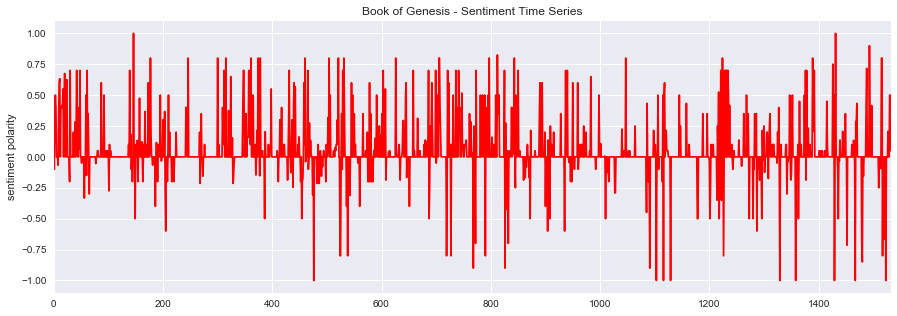

In [210]:
#Sentiment time series for entire Bible from Genesis (1st book) to Revelation (66th book)
sentiment_Genesis = pd.Series(data=df_Genesis['sentiment'].values, 
                            index=df_Genesis.index).astype(float)
    
plt.title("Book of Genesis - Sentiment Time Series")
plt.ylabel("sentiment polarity")
sentiment_Genesis.plot(figsize=(15,5), color=random.choice(['b', 'g', 'r', 'c', 'm', 'y', 'k']));
plt.show()

In [211]:
#Load the genre key from csv file (has to be in the same folder as the notebook)
df_key_1 = pd.read_csv('./key_genre_english.csv')
df_key_1.head(10)

g            n
0  1          Law
1  2      History
2  3       Wisdom
3  4     Prophets
4  5      Gospels
5  6         Acts
6  7     Epistles
7  8  Apocalyptic

In [212]:
#Rename the columns so that when merging the data frames the column names will be unique
df_key_1.columns = ['genre_ID', 'genre']
df_key_1.head(10)

genre_ID        genre
0         1          Law
1         2      History
2         3       Wisdom
3         4     Prophets
4         5      Gospels
5         6         Acts
6         7     Epistles
7         8  Apocalyptic

In [213]:
#Load the genre-to-book key from csv file (has to be in the same folder as the notebook)
df_key_2 = pd.read_csv('./key_english.csv')
df_key_2.head(10)

b            n   t  g
0   1      Genesis  OT  1
1   2       Exodus  OT  1
2   3    Leviticus  OT  1
3   4      Numbers  OT  1
4   5  Deuteronomy  OT  1
5   6       Joshua  OT  2
6   7       Judges  OT  2
7   8         Ruth  OT  2
8   9     1 Samuel  OT  2
9  10     2 Samuel  OT  2

In [214]:
#Rename the columns so that when merging the data frames the column names will be unique
df_key_2.columns = ['book_ID', 'book', 'testament', 'genre_ID']
df_key_2.head(10)

book_ID         book testament  genre_ID
0        1      Genesis        OT         1
1        2       Exodus        OT         1
2        3    Leviticus        OT         1
3        4      Numbers        OT         1
4        5  Deuteronomy        OT         1
5        6       Joshua        OT         2
6        7       Judges        OT         2
7        8         Ruth        OT         2
8        9     1 Samuel        OT         2
9       10     2 Samuel        OT         2

In [215]:
#inner join merge the two key data frames 'df_key_1' with 'df_key_2', 
df_key_merge = pd.merge(df_key_1, df_key_2, on='genre_ID', how='inner')
df_key_merge.head(10)

genre_ID    genre  book_ID         book testament
0         1      Law        1      Genesis        OT
1         1      Law        2       Exodus        OT
2         1      Law        3    Leviticus        OT
3         1      Law        4      Numbers        OT
4         1      Law        5  Deuteronomy        OT
5         2  History        6       Joshua        OT
6         2  History        7       Judges        OT
7         2  History        8         Ruth        OT
8         2  History        9     1 Samuel        OT
9         2  History       10     2 Samuel        OT

In [217]:
# merge the main data frame 'df_key_merge' with 'df_Bible' using an 'inner join' 
# using the 'book_ID' column
df_Bible_keys = pd.merge(df_key_merge, df_Bible, on='book_ID', how='inner')
df_Bible_keys.head(10)

genre_ID genre  book_ID     book testament  unique_ID  chapter_ID  \
0         1   Law        1  Genesis        OT    1001001           1   
1         1   Law        1  Genesis        OT    1001002           1   
2         1   Law        1  Genesis        OT    1001003           1   
3         1   Law        1  Genesis        OT    1001004           1   
4         1   Law        1  Genesis        OT    1001005           1   
5         1   Law        1  Genesis        OT    1001006           1   
6         1   Law        1  Genesis        OT    1001007           1   
7         1   Law        1  Genesis        OT    1001008           1   
8         1   Law        1  Genesis        OT    1001009           1   
9         1   Law        1  Genesis        OT    1001010           1   

   verse_ID                                               text  \
0         1  In the beginning God created the heavens and t...   
1         2  And the earth was waste and void; and darkness...   
2         3  And God said, Let there be light: and there wa...   
3         4  And God saw the light, that it was good: and G...   
4         5  And God called the light Day, and the darkness...   
5         6  And God said, Let there be a firmament in the ...   
6         7  And God made the firmament, and divided the wa...   
7         8  And God called the firmament Heaven. And there...   
8         9  And God said, Let the waters under the heavens...   
9        10  And God called the dry land Earth; and the gat...   

                                          clean_text sentiment  
0                 beginning god created heaven earth    0.0000  
1  earth waste void darkness upon face deep spiri...   -0.1000  
2                           god said let light light    0.4000  
3      god saw light good god divided light darkness    0.5000  
4  god called light day darkness called night eve...    0.4000  
5  god said let firmament midst water let divide ...    0.0000  
6  god made firmament divided water firmament wat...    0.0000  
7  god called firmament heaven evening morning se...    0.0000  
8  god said let water heaven gathered together un...   -0.0667  
9  god called dry land earth gathering together w...    0.3167

In [218]:
df_Bible_keys.shape

(31103, 11)

In [219]:
# get list of unique genre labels
genre_labels = pd.unique(df_Bible_keys.genre)
print(genre_labels)

['Law' 'History' 'Wisdom' 'Prophets' 'Gospels' 'Acts' 'Epistles'
 'Apocalyptic']


In [220]:
#First check the value counts for each genre
df_Bible_keys.genre.value_counts()

History        7018
Law            5852
Prophets       5490
Wisdom         4785
Gospels        3779
Epistles       2768
Acts           1007
Apocalyptic     404
Name: genre, dtype: int64

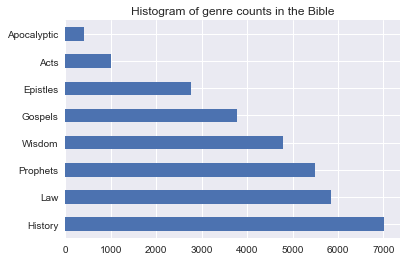

In [221]:
genre_counts = pd.value_counts(df_Bible_keys.genre.values, sort=True)
genre_counts.plot.barh(title="Histogram of genre counts in the Bible")

In [222]:
# create independent and dependent variables for classification
X = df_Bible_keys['clean_text']
y = df_Bible_keys['genre']

In [223]:
from sklearn.model_selection import train_test_split

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [224]:
# number of train and test samples
print(X_train.shape)
print(X_test.shape)

(20839,)
(10264,)


In [225]:
# instantiate the vectorizer
vect = CountVectorizer()

In [226]:
# learn training data vocabulary and create document-term matrix
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<20839x10268 sparse matrix of type '<class 'numpy.int64'>'
	with 228016 stored elements in Compressed Sparse Row format>

In [227]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<10264x10268 sparse matrix of type '<class 'numpy.int64'>'
	with 110088 stored elements in Compressed Sparse Row format>

In [228]:
# use multinomial NaiveBayes classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [229]:
y_pred_class = nb.predict(X_test_dtm)

In [230]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.724473889322


In [231]:
# confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[ 102    0   30  138   27   17   23    4]
 [   1   29   12   24    6   16   30   12]
 [   5    0  695   80   22   36   38   60]
 [   8    1   56  944   59   56   63   39]
 [   3    0    4   32 1850  191  156   56]
 [   0    2    8   41  200 1428  190   67]
 [   0    4    9   34  173   99 1303  179]
 [   2    3   39   26   73   85  289 1085]]


In [232]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = y_pred_class
target_names = genre_labels
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

        Law       0.84      0.30      0.44       341
    History       0.74      0.22      0.34       130
     Wisdom       0.81      0.74      0.78       936
   Prophets       0.72      0.77      0.74      1226
    Gospels       0.77      0.81      0.79      2292
       Acts       0.74      0.74      0.74      1936
   Epistles       0.62      0.72      0.67      1801
Apocalyptic       0.72      0.68      0.70      1602

avg / total       0.73      0.72      0.72     10264



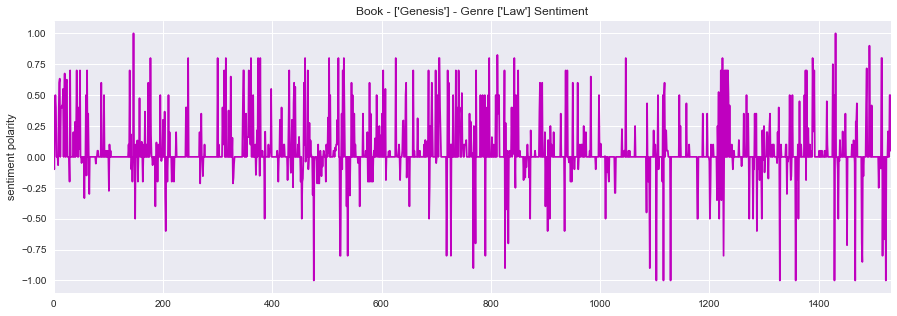

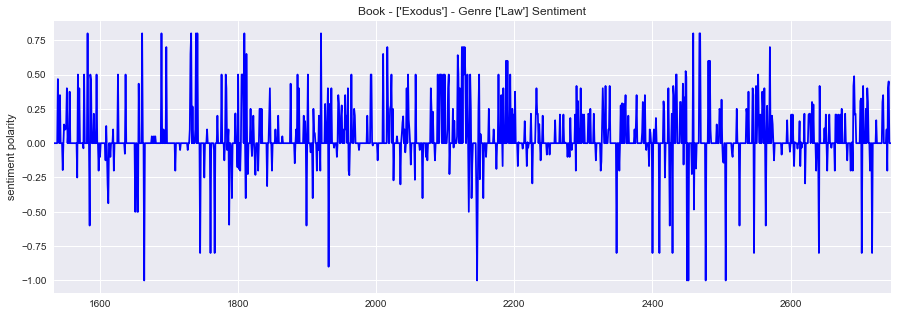

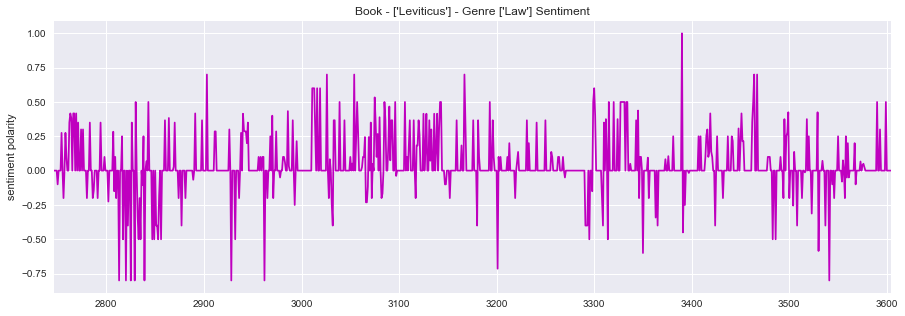

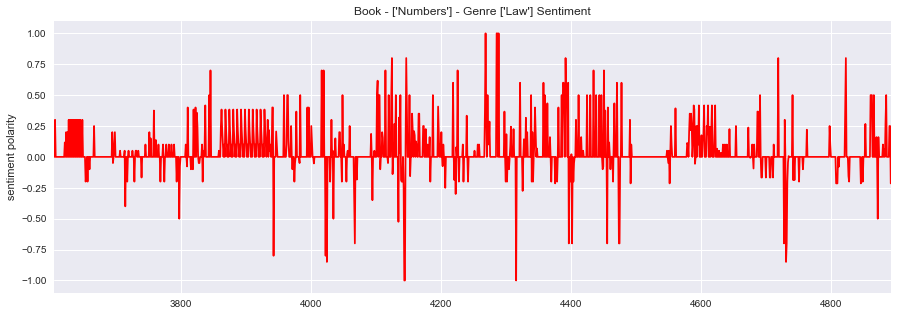

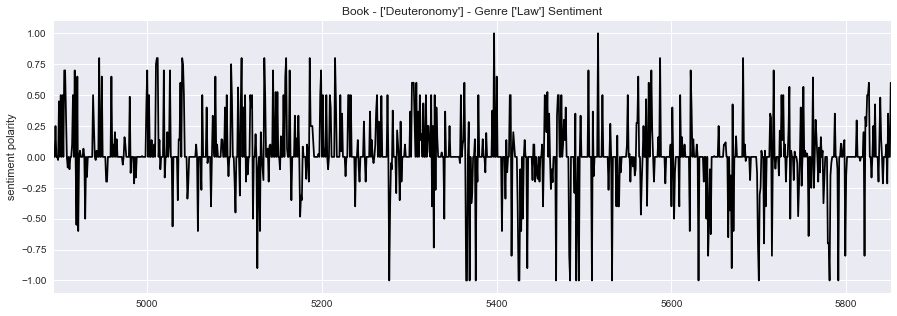

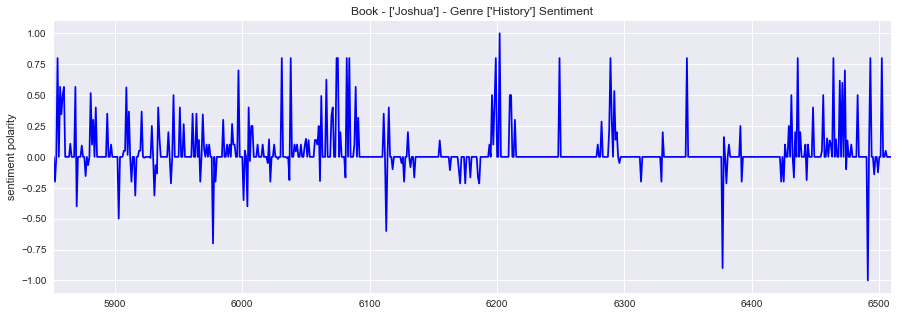

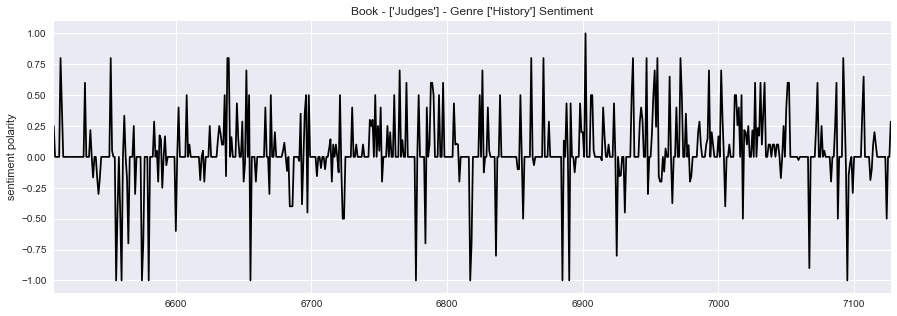

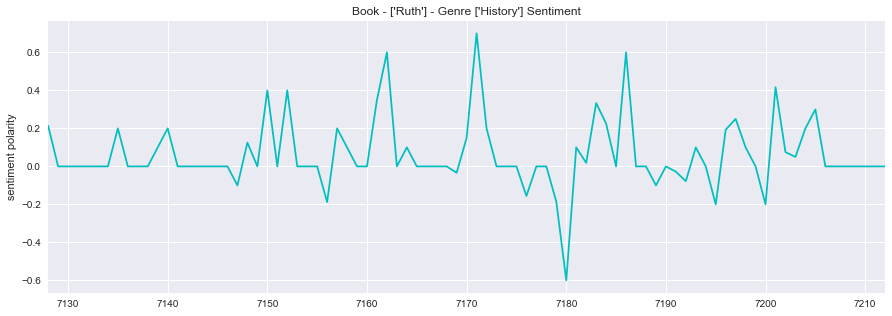

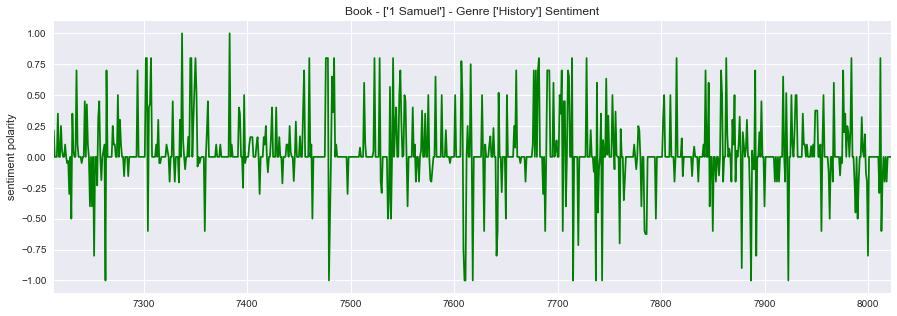

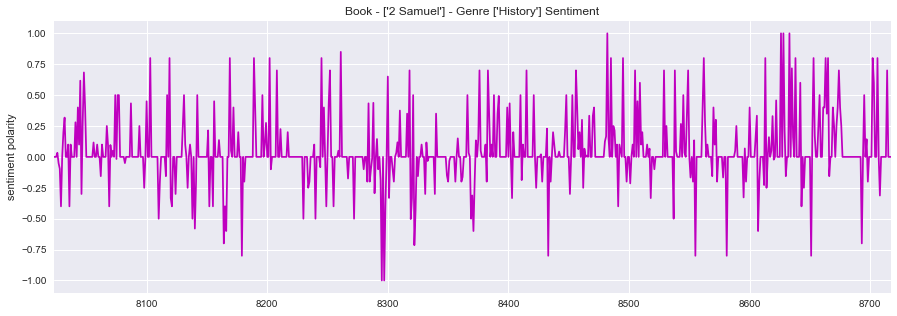

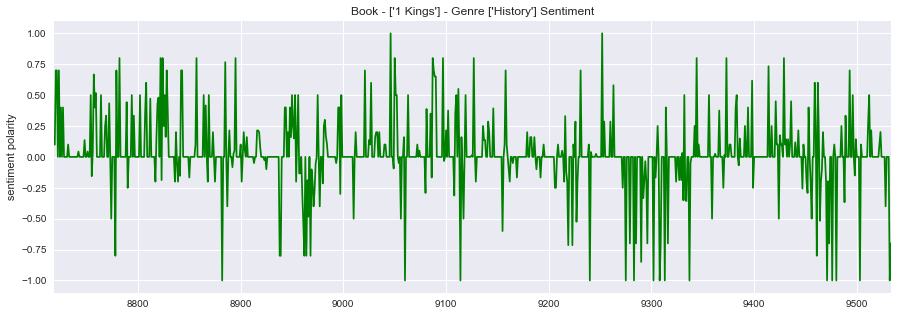

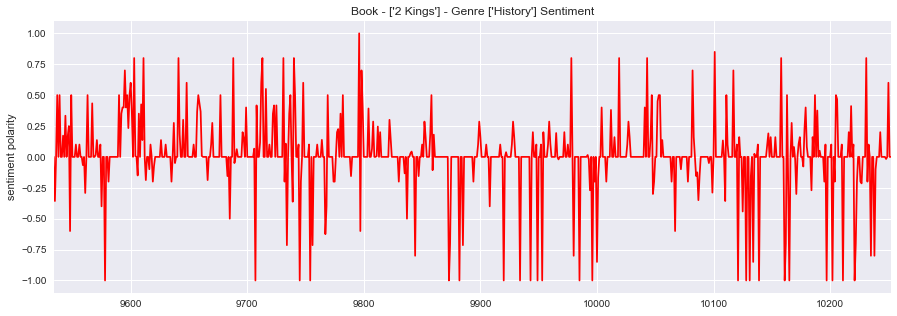

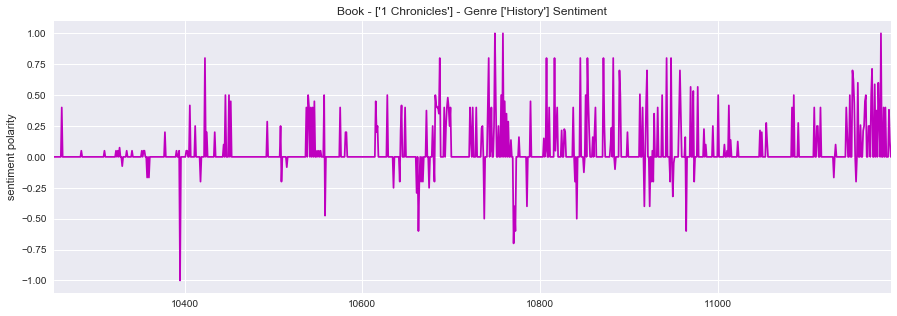

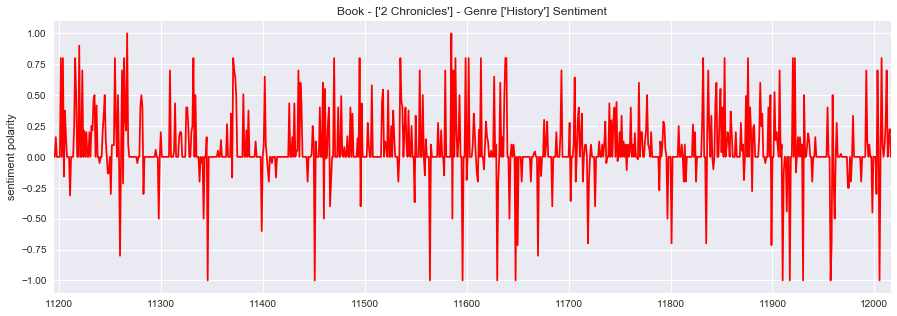

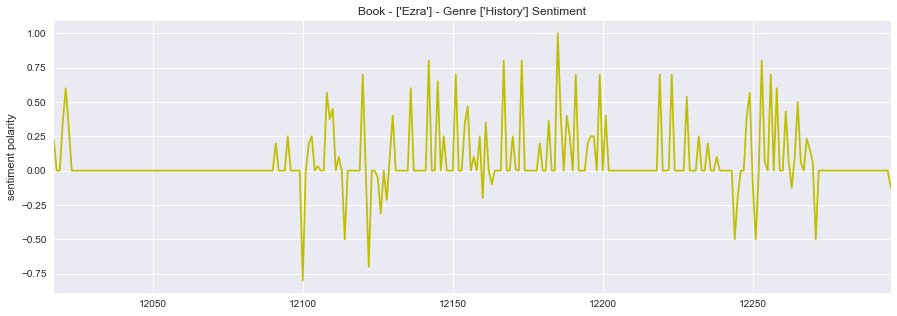

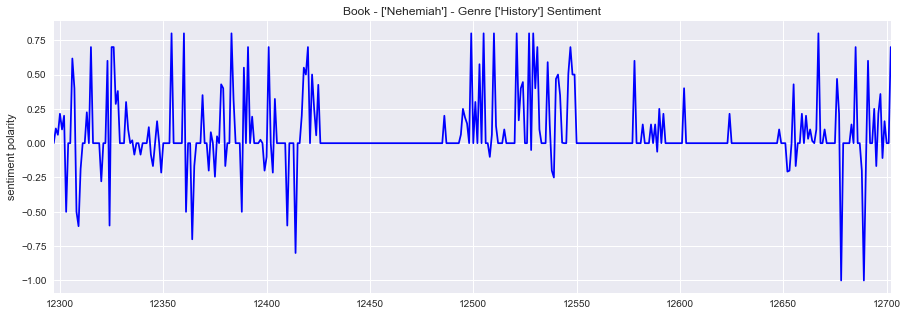

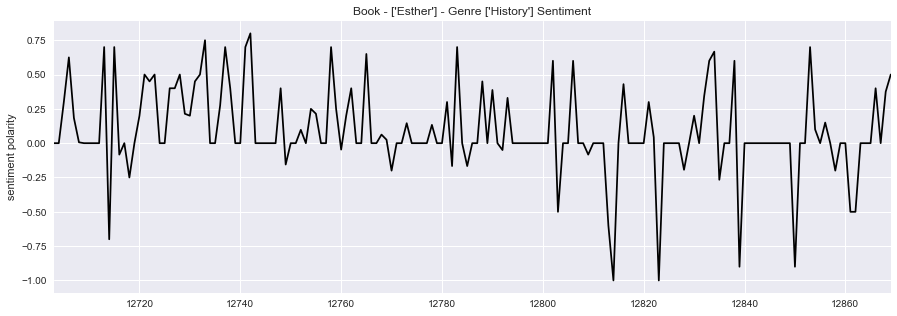

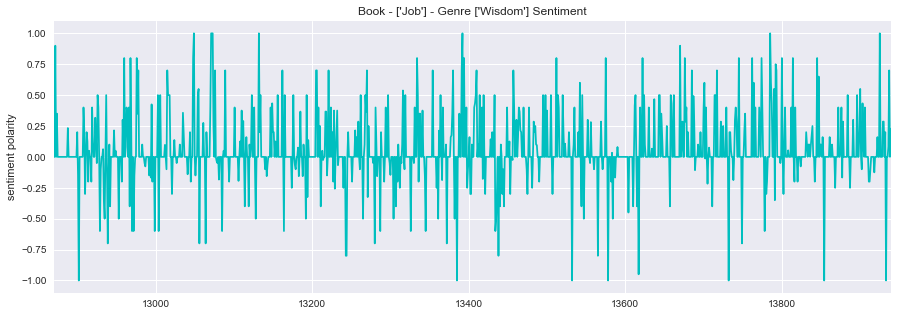

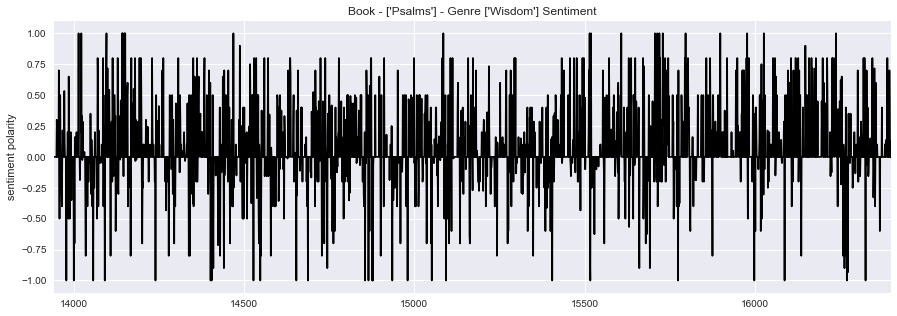

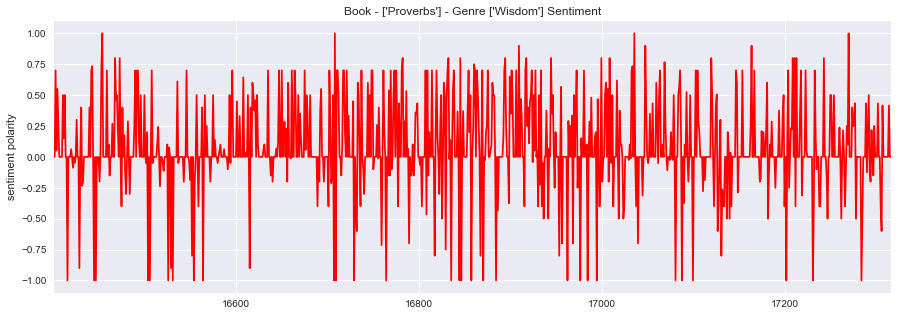

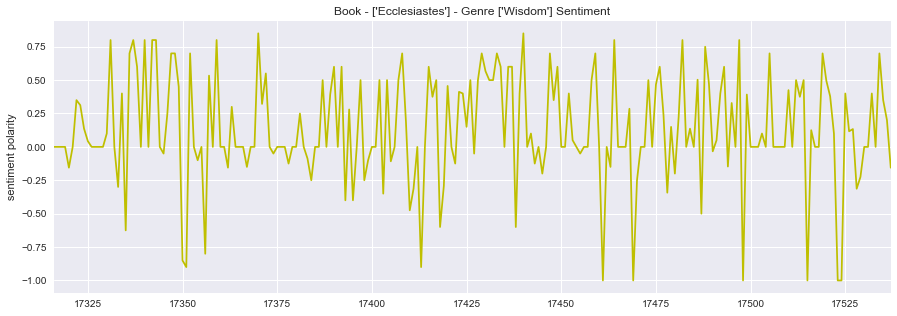

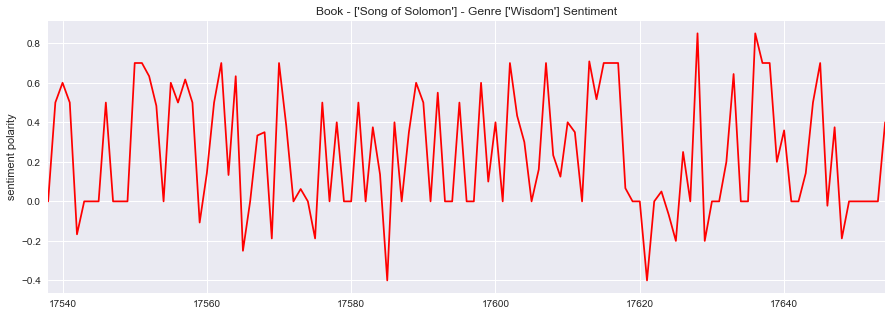

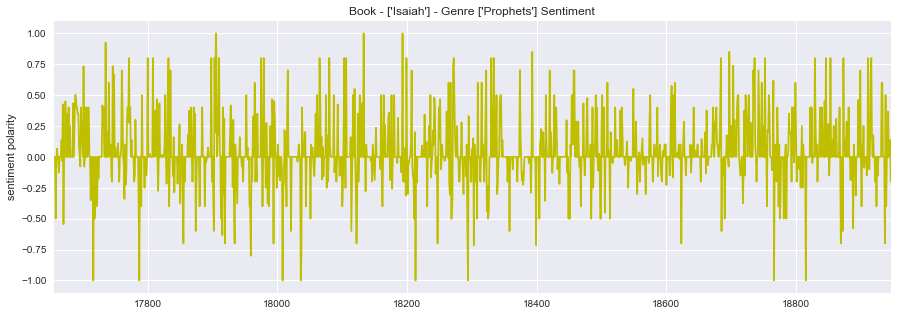

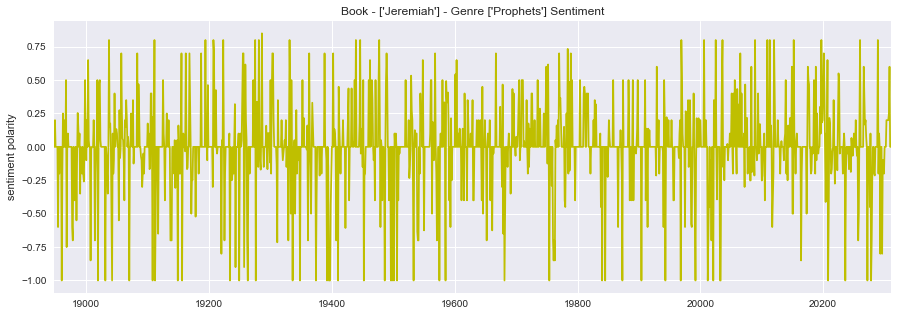

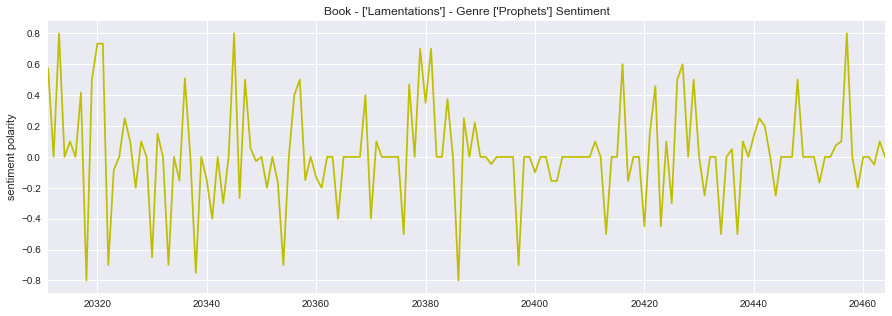

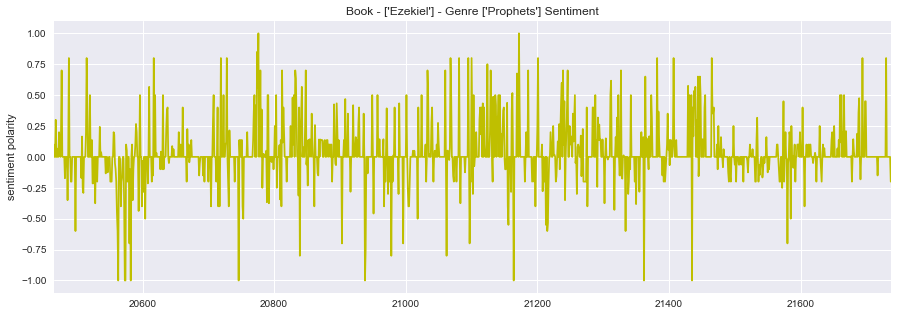

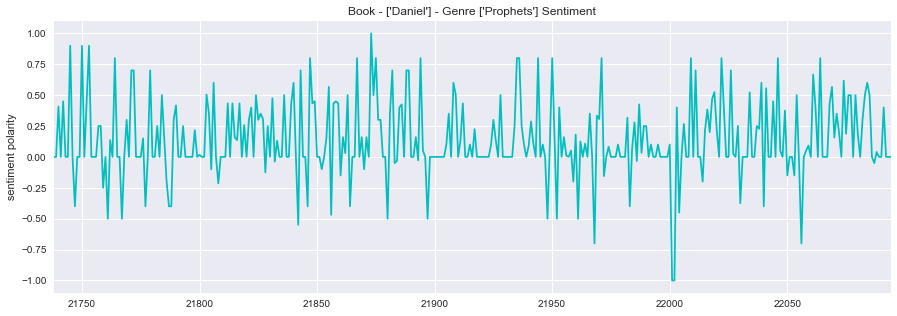

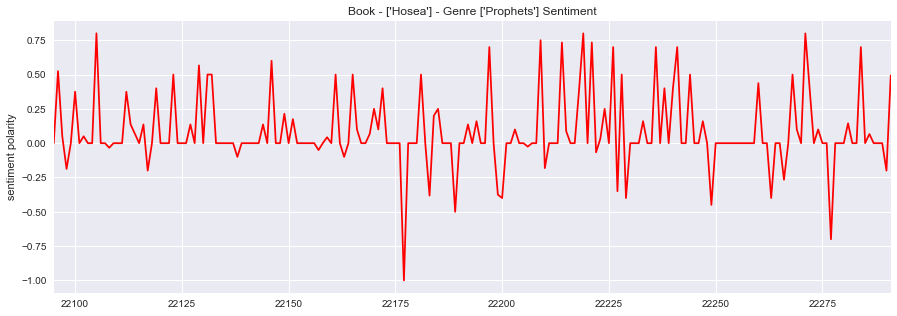

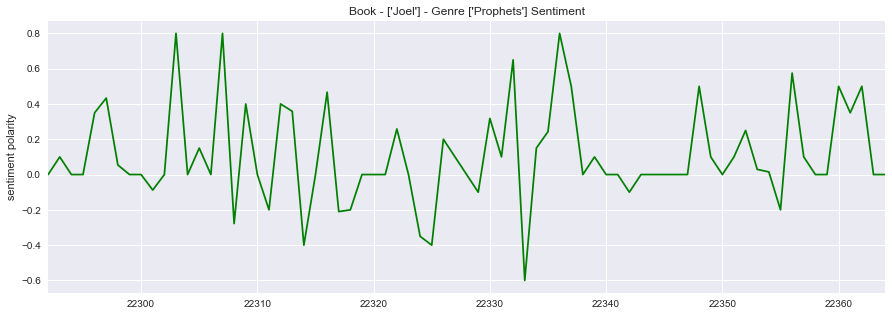

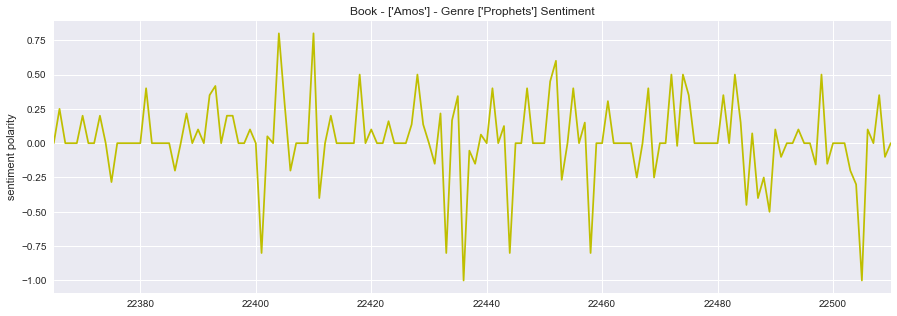

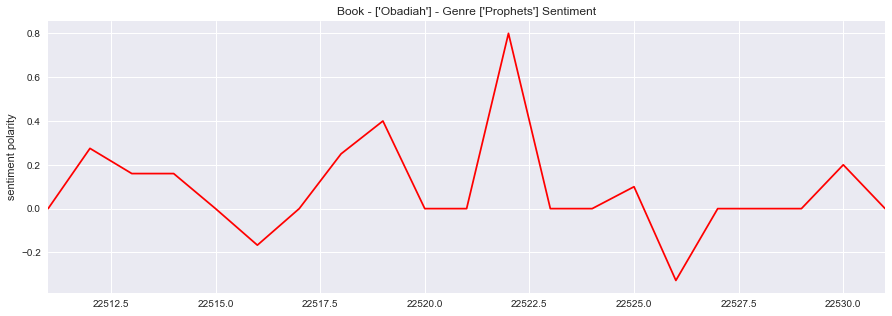

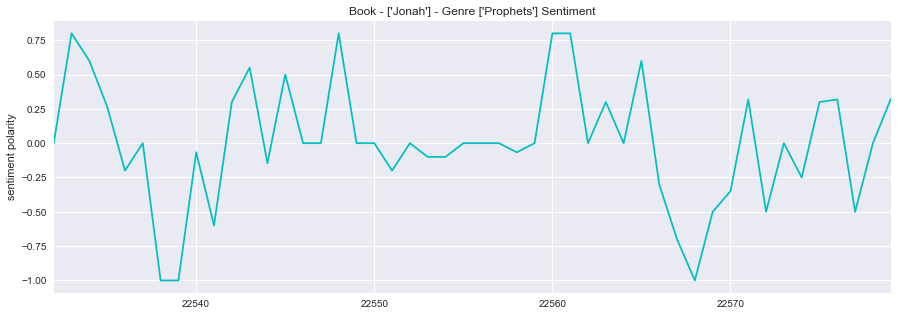

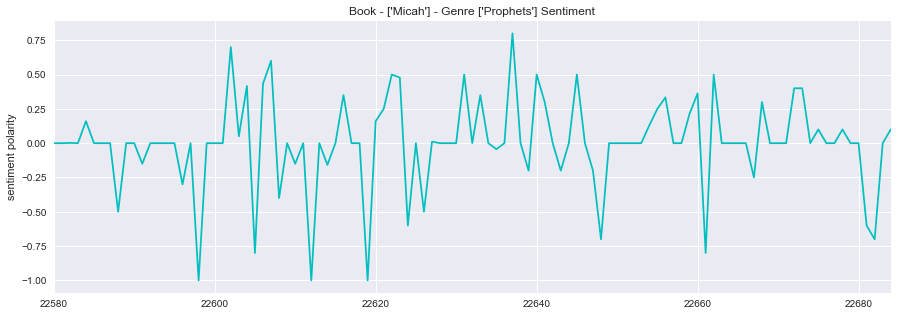

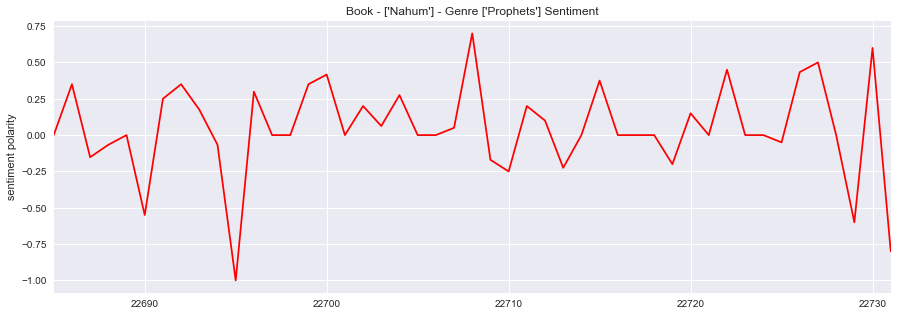

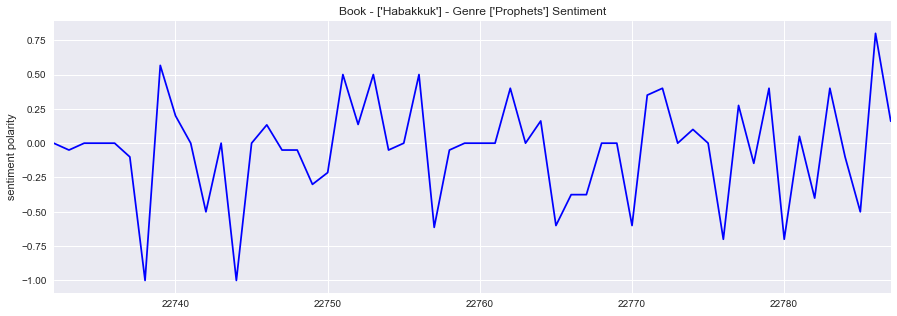

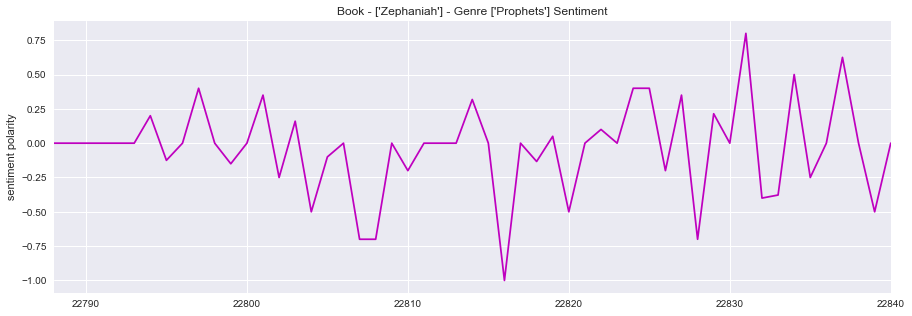

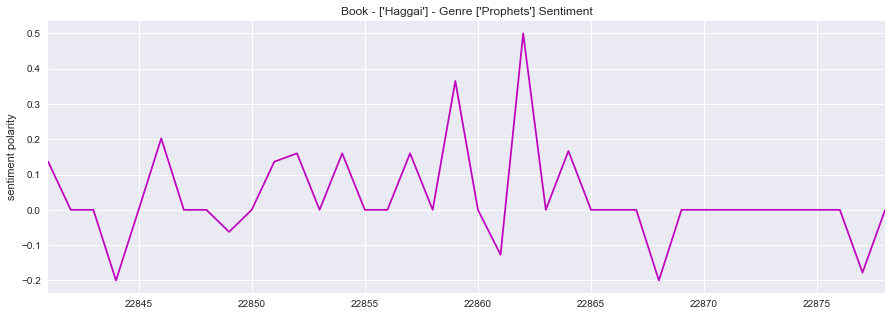

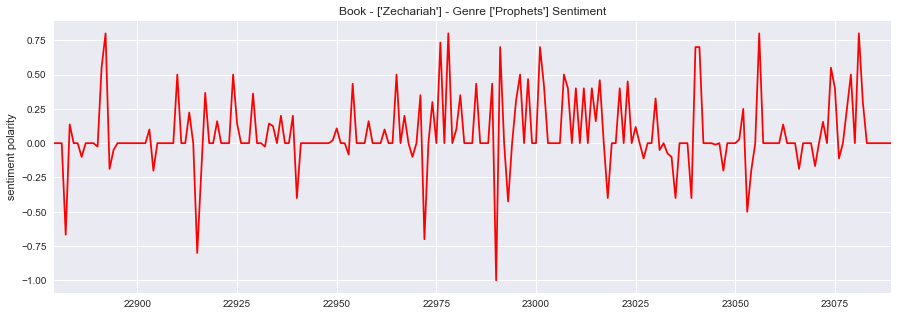

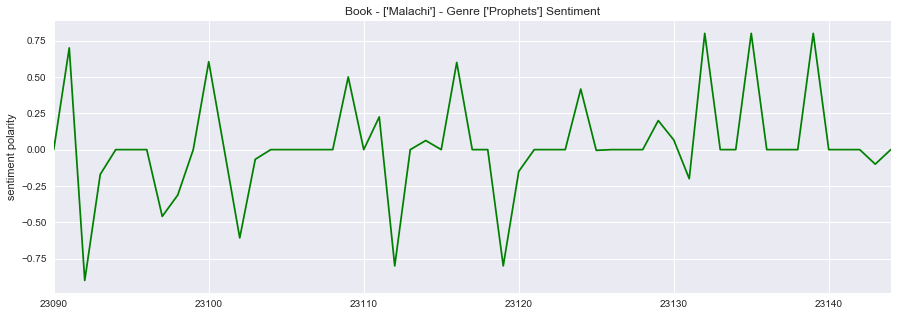

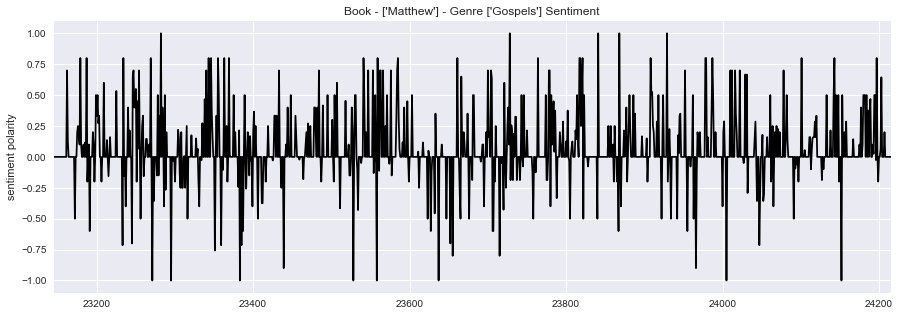

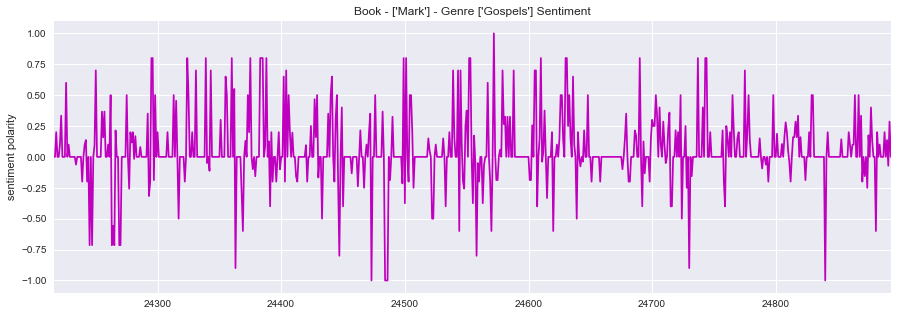

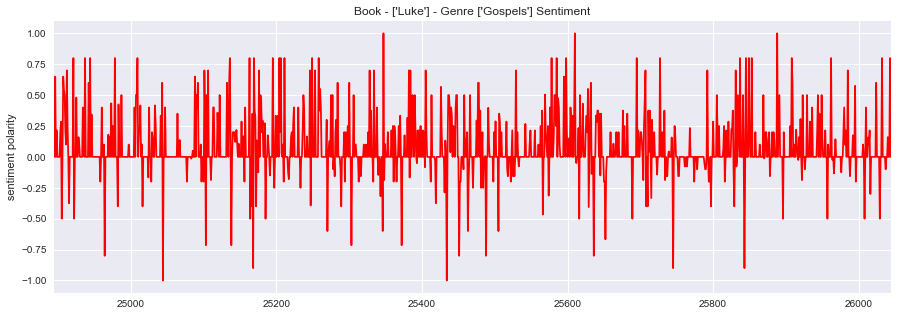

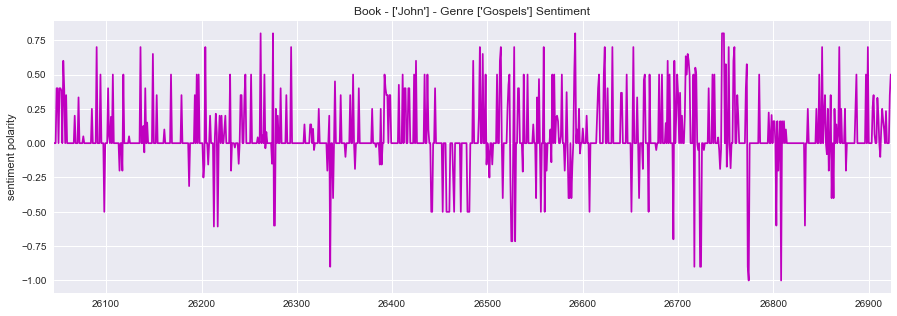

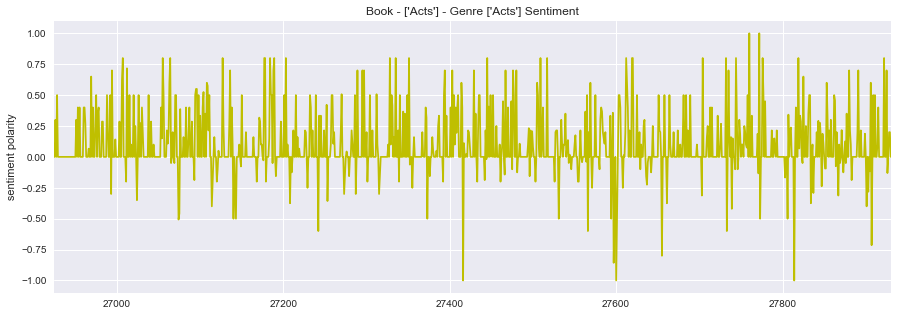

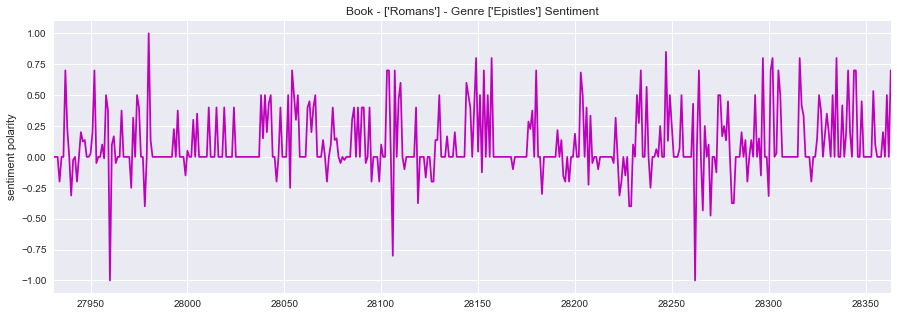

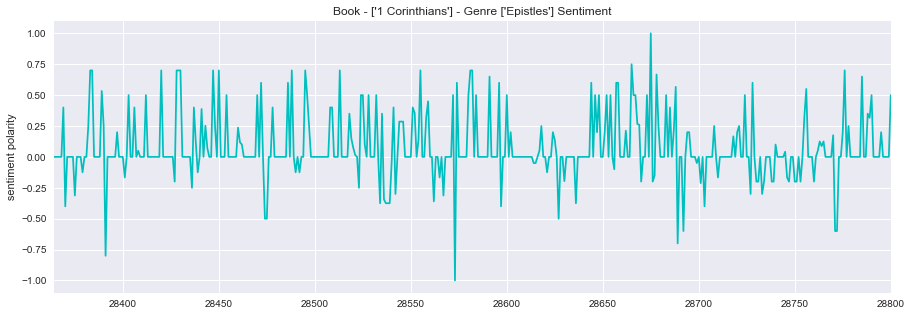

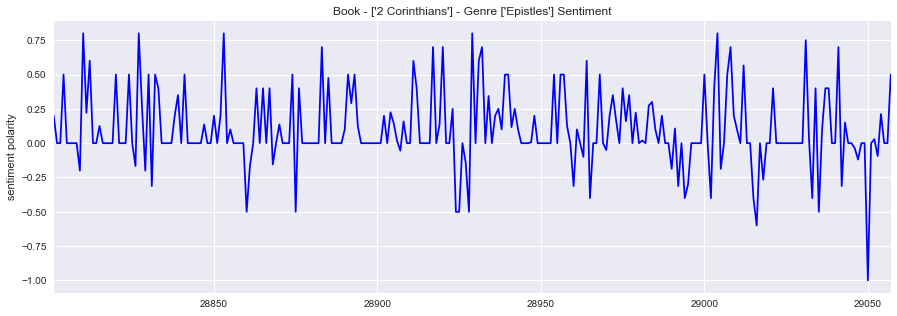

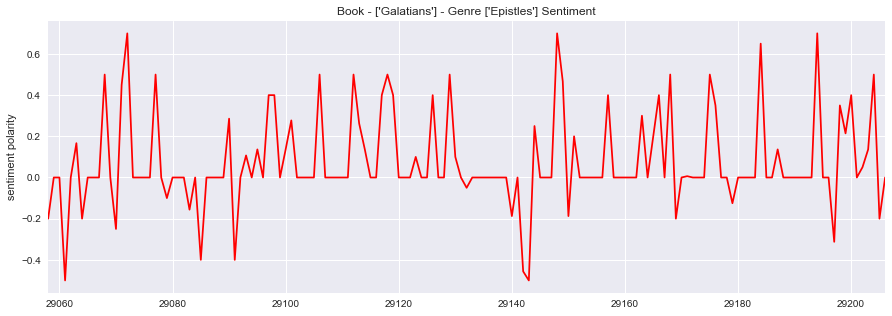

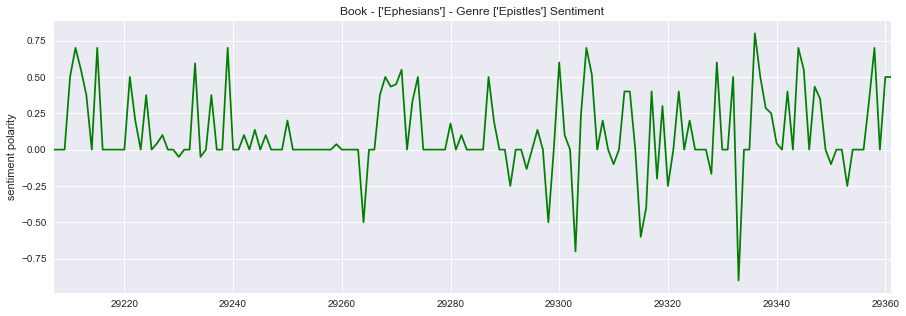

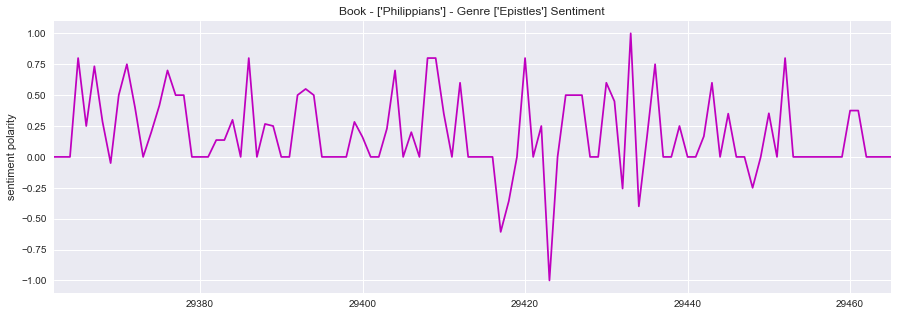

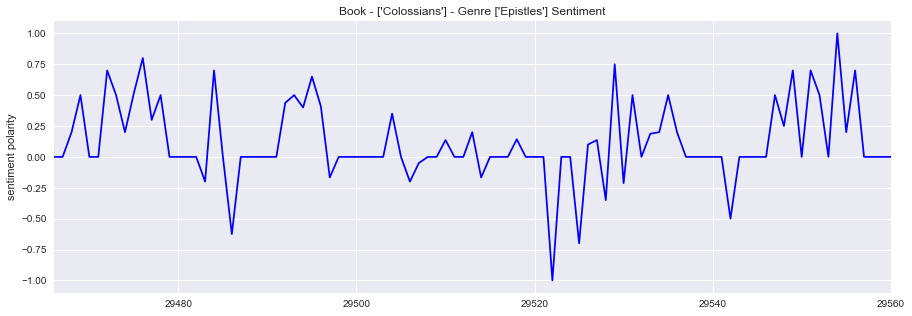

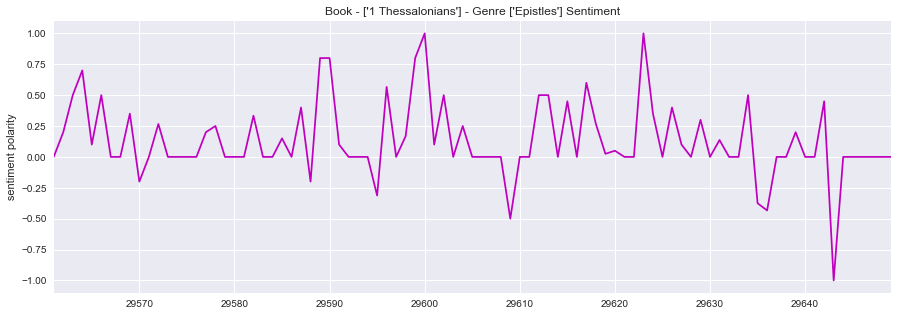

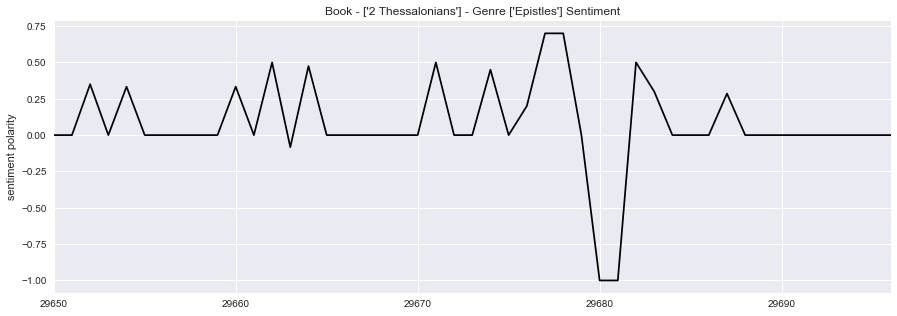

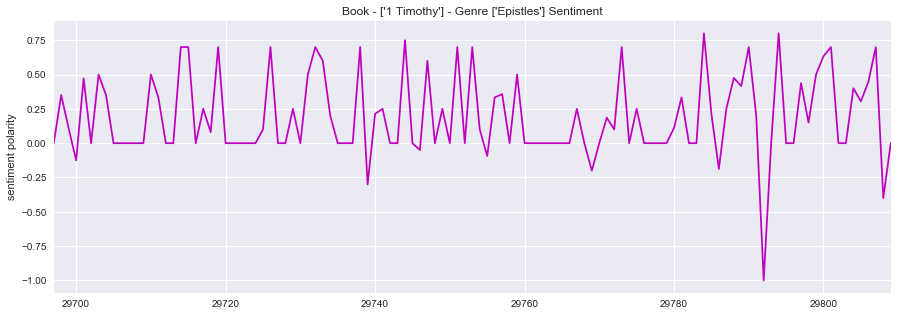

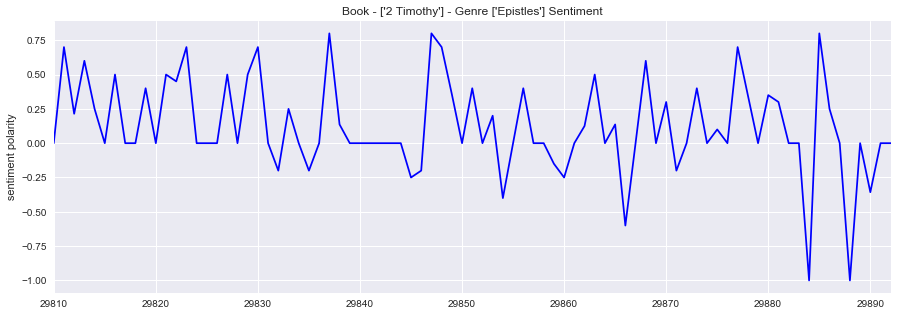

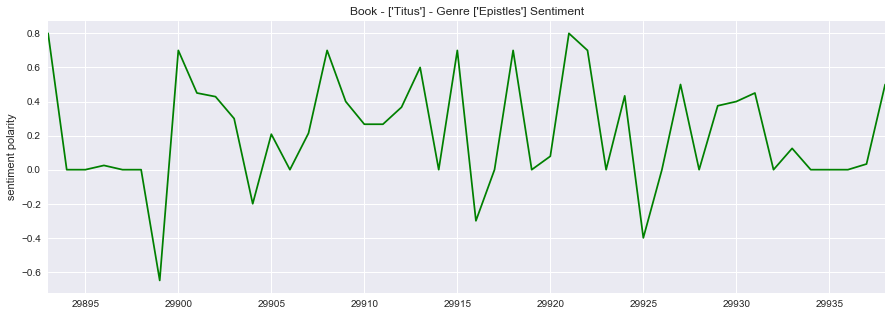

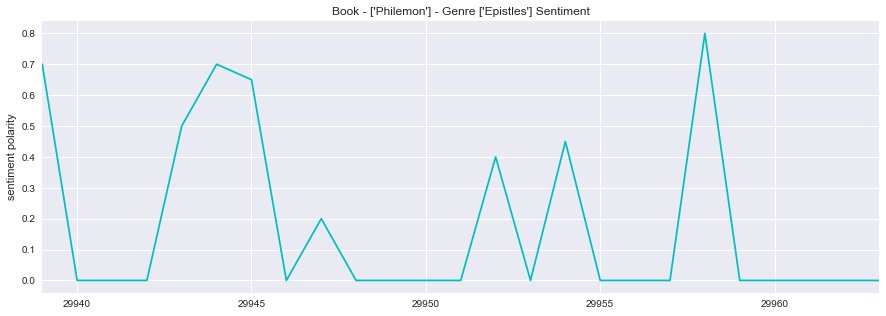

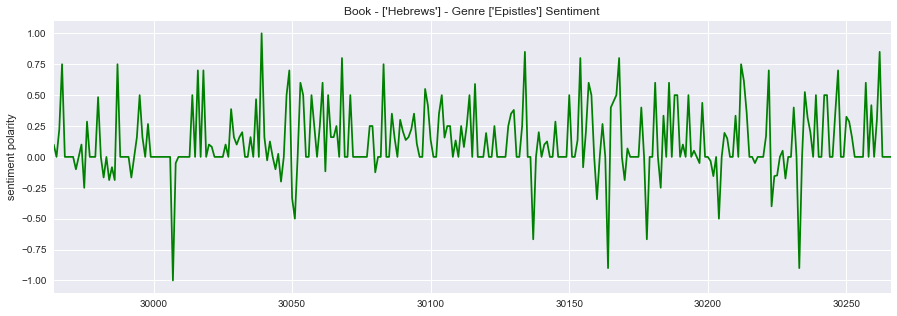

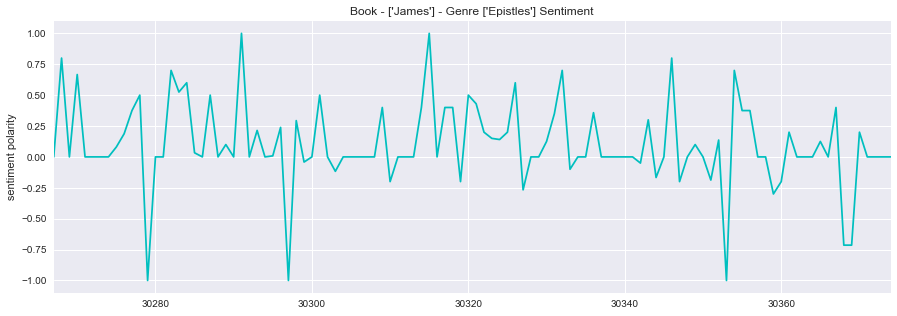

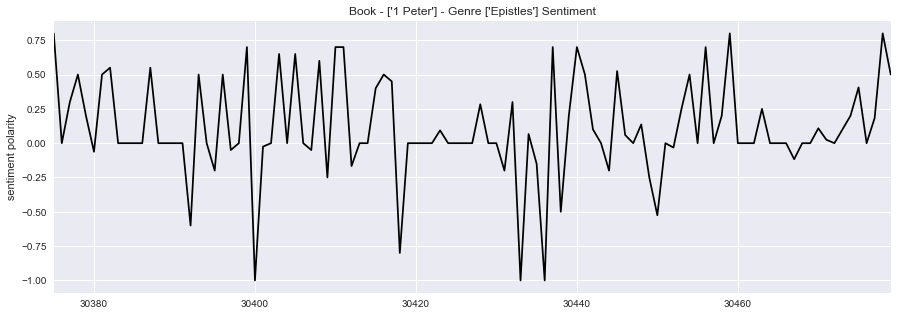

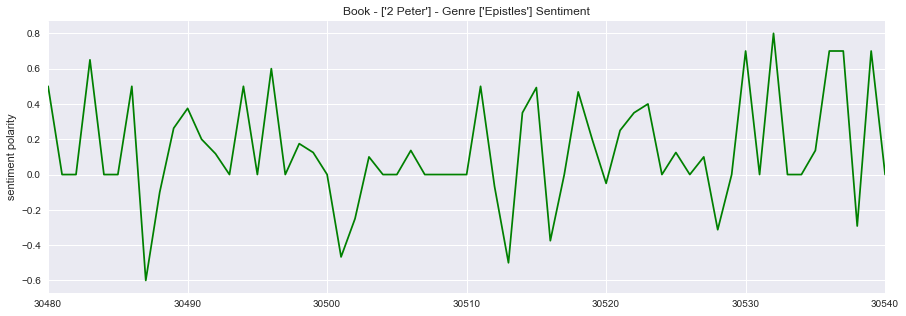

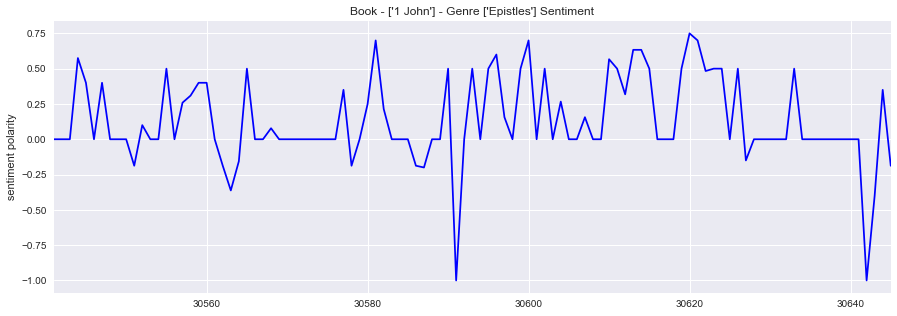

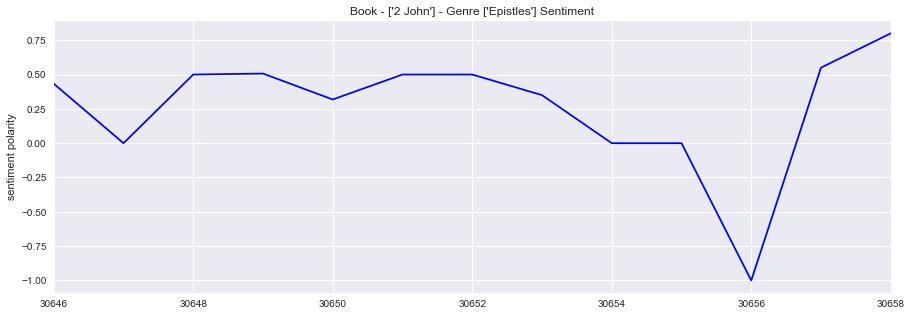

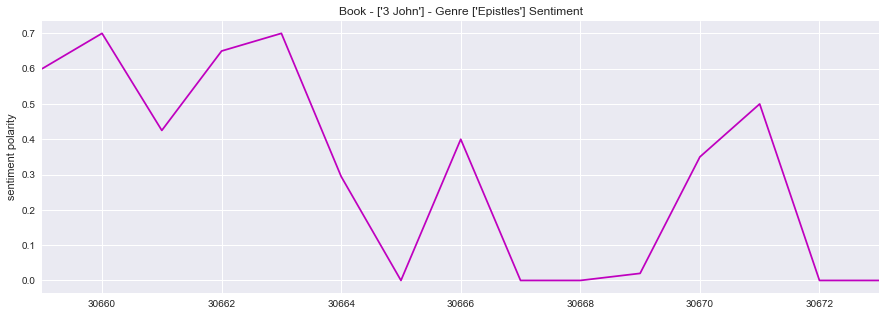

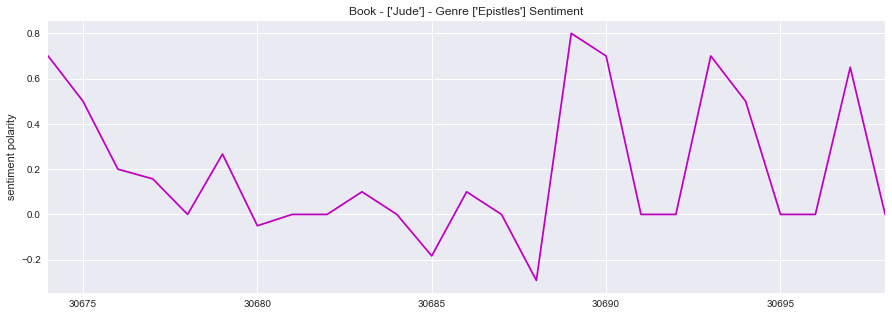

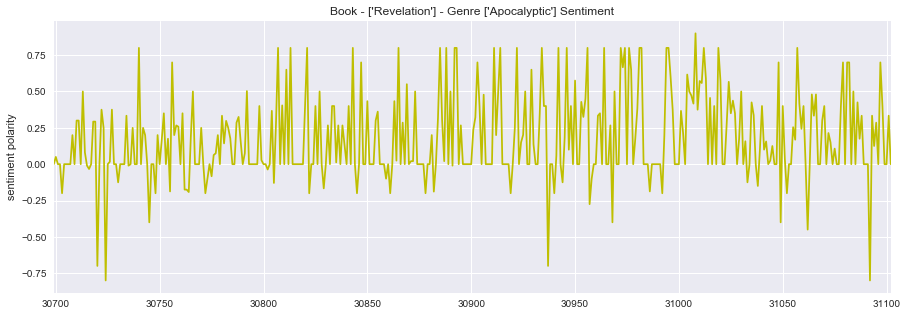

In [233]:
#Bonus round:
# plot a sentiment time series per book in the Bible
for book_id in df_Bible_keys['book_ID'].unique():
    df_book = df_Bible_keys[df_Bible_keys['book_ID']== book_id]
    df_book.reset_index(drop=True)
    genre = df_book.genre.unique()
    book_title = df_book.book.unique()
    sentiment_book = pd.Series(data=df_book['sentiment'].values, index=df_book.index).astype(float)
    plt.title("Book - %s - Genre %s Sentiment"%(book_title,genre))
    plt.ylabel("sentiment polarity")
    sentiment_book.plot(figsize=(15,5), color=random.choice(['b', 'g', 'r', 'c', 'm', 'y', 'k']));
    plt.show()